In [2]:
import os
from pathlib import Path
import hashlib
import requests
from typing import Dict, List, Optional

import zipfile
import shutil

import pandas as pd
from tqdm.auto import tqdm

In [3]:
# Root directory where all data will be stored.
DATA_ROOT = Path("./sts_tooth_data").resolve()
DATA_ROOT.mkdir(parents=True, exist_ok=True)

# Subdirectories:
# - downloads: raw .zip.001, .zip.002, ... files
# - raw: extracted content from SD-Tooth.zip
# - processed_2d: cleaned & reorganized 2D images
DOWNLOAD_DIR = DATA_ROOT / "downloads"
RAW_DIR = DATA_ROOT / "raw"
PROCESSED_2D_DIR = DATA_ROOT / "processed_2d"

DOWNLOAD_DIR.mkdir(exist_ok=True)
RAW_DIR.mkdir(exist_ok=True)
PROCESSED_2D_DIR.mkdir(exist_ok=True)

print("DATA_ROOT:", DATA_ROOT)

DATA_ROOT: /content/sts_tooth_data


In [4]:
# Download all 15 split zip parts

# %% [markdown]
# ## Step 1 (faster): Download all 15 split zip parts in parallel
#
# This is an accelerated version of the download step.
#
# Main changes compared to the original version:
# - We use a ThreadPoolExecutor to download several parts in parallel.
# - We use a single `requests.Session()` object (connection reuse).
# - Already existing files are still skipped.
#
# Note:
# - If your network is unstable, you can reduce `MAX_WORKERS` (e.g. 2).
# - If your bandwidth is good, you can try increasing it to 6–8.

# %%
from concurrent.futures import ThreadPoolExecutor
import itertools

# Zenodo record ID for STS-Tooth
ZENODO_RECORD_ID = "10597292"

# Expected MD5 checksums from the Zenodo page.
EXPECTED_MD5: Dict[str, str] = {
    "SD-Tooth.zip.001": "9fff54c469d2f5706332d01fd362178e",
    "SD-Tooth.zip.002": "eb5be6735f8a20b469bef46a26784f3c",
    "SD-Tooth.zip.003": "1ee5ce98fbfadeb48b2c264ac425ff20",
    "SD-Tooth.zip.004": "12b7b965b1d7330c10850a40324368fd",
    "SD-Tooth.zip.005": "1348eaf36bed8da9aabd5748a70a3d51",
    "SD-Tooth.zip.006": "f0a2158d0cc915507ccefc53067b6a74",
    "SD-Tooth.zip.007": "d728cec1d10e05845d33d2a3480c1cf9",
    "SD-Tooth.zip.008": "af917049b72b512c4eae0d2801811b16",
    "SD-Tooth.zip.009": "699713928665b2c15537d665689c7bdd",
    "SD-Tooth.zip.010": "6ba5b3100fd516f031b68bc13868e0bb",
    "SD-Tooth.zip.011": "82e5df4d8dda37a45ea1725b6b21942b",
    "SD-Tooth.zip.012": "d7896f01462a4a1589f9f006e3c97190",
    "SD-Tooth.zip.013": "763728b43b93cf081cc28ca15d4490a1",
    "SD-Tooth.zip.014": "9cba0607e1d8066cd5aaac5c8091ee6a",
    "SD-Tooth.zip.015": "0be8577f58e8bc1937f8e162887c4654",
}


def build_part_filename(idx: int) -> str:
    """
    Build a local filename for the given index.

    Example:
        idx = 1 -> "SD-Tooth.zip.001"
        idx = 2 -> "SD-Tooth.zip.002"
    """
    return f"SD-Tooth.zip.{idx:03d}"


def build_part_url(idx: int) -> str:
    """
    Build the remote download URL for a given part.

    This follows the Zenodo file download pattern:
        https://zenodo.org/records/<record_id>/files/<filename>?download=1
    """
    part_name = build_part_filename(idx)
    return f"https://zenodo.org/records/{ZENODO_RECORD_ID}/files/{part_name}?download=1"


def md5sum(path: Path, chunk_size: int = 1024 * 1024) -> str:
    """
    Compute the MD5 checksum of a file in a memory-efficient way.
    """
    h = hashlib.md5()
    with path.open("rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()


# Create a session to reuse HTTP connections across downloads
_session = requests.Session()


def download_file(url: str, dst: Path, chunk_size: int = 4 * 1024 * 1024) -> None:
    """
    Download a file from `url` to `dst`, showing a progress bar.

    If the destination file already exists, the download is skipped.

    Args:
        url: Remote URL.
        dst: Local file path.
        chunk_size: Number of bytes read per iteration (4 MB by default).
    """
    if dst.exists():
        print(f"[skip] file already exists: {dst.name}")
        return

    print(f"[download] {dst.name} <- {url}")
    with _session.get(url, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("Content-Length", 0)) or None
        with dst.open("wb") as f, tqdm(
            total=total, unit="B", unit_scale=True, desc=dst.name
        ) as pbar:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))


def download_one_part(idx: int):
    """
    Helper wrapper for ThreadPoolExecutor.

    It builds the filename and URL for a given part index and then
    calls `download_file`.
    """
    filename = build_part_filename(idx)
    url = build_part_url(idx)
    dst = DOWNLOAD_DIR / filename
    download_file(url, dst)
    return filename


# Number of parallel workers (you can tune this)
MAX_WORKERS = 6

print(f"Starting parallel download with {MAX_WORKERS} workers...")

# We wrap the executor.map call with tqdm so we see progress over the 15 parts.
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    list(
        tqdm(
            executor.map(download_one_part, range(1, 16)),
            total=15,
            desc="Downloading parts",
        )
    )

print("All parts have finished the download step (existing files were skipped).")


Starting parallel download with 6 workers...
[download] SD-Tooth.zip.001 <- https://zenodo.org/records/10597292/files/SD-Tooth.zip.001?download=1
[download] SD-Tooth.zip.002 <- https://zenodo.org/records/10597292/files/SD-Tooth.zip.002?download=1
[download] SD-Tooth.zip.003 <- https://zenodo.org/records/10597292/files/SD-Tooth.zip.003?download=1
[download] SD-Tooth.zip.004 <- https://zenodo.org/records/10597292/files/SD-Tooth.zip.004?download=1
[download] SD-Tooth.zip.005 <- https://zenodo.org/records/10597292/files/SD-Tooth.zip.005?download=1
[download] SD-Tooth.zip.006 <- https://zenodo.org/records/10597292/files/SD-Tooth.zip.006?download=1


SD-Tooth.zip.001:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

SD-Tooth.zip.006:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

SD-Tooth.zip.004:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

SD-Tooth.zip.002:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

SD-Tooth.zip.003:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

SD-Tooth.zip.005:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

[download] SD-Tooth.zip.007 <- https://zenodo.org/records/10597292/files/SD-Tooth.zip.007?download=1


SD-Tooth.zip.007:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

[download] SD-Tooth.zip.008 <- https://zenodo.org/records/10597292/files/SD-Tooth.zip.008?download=1


SD-Tooth.zip.008:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

[download] SD-Tooth.zip.009 <- https://zenodo.org/records/10597292/files/SD-Tooth.zip.009?download=1


SD-Tooth.zip.009:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

[download] SD-Tooth.zip.010 <- https://zenodo.org/records/10597292/files/SD-Tooth.zip.010?download=1


SD-Tooth.zip.010:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

[download] SD-Tooth.zip.012 <- https://zenodo.org/records/10597292/files/SD-Tooth.zip.012?download=1
[download] SD-Tooth.zip.011 <- https://zenodo.org/records/10597292/files/SD-Tooth.zip.011?download=1


SD-Tooth.zip.011:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

SD-Tooth.zip.012:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

[download] SD-Tooth.zip.013 <- https://zenodo.org/records/10597292/files/SD-Tooth.zip.013?download=1


SD-Tooth.zip.013:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

[download] SD-Tooth.zip.014 <- https://zenodo.org/records/10597292/files/SD-Tooth.zip.014?download=1


SD-Tooth.zip.014:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

[download] SD-Tooth.zip.015 <- https://zenodo.org/records/10597292/files/SD-Tooth.zip.015?download=1


SD-Tooth.zip.015:   0%|          | 0.00/1.76G [00:00<?, ?B/s]

All parts have finished the download step (existing files were skipped).


In [4]:
# Optional MD5 verification
def verify_md5_all() -> bool:
    """
    Verify the MD5 checksum of all downloaded parts.

    Returns:
        True if all files are present and all MD5 checksums match,
        False otherwise.
    """
    ok = True
    for name, expected in EXPECTED_MD5.items():
        path = DOWNLOAD_DIR / name
        if not path.exists():
            print(f"[missing] {name}")
            ok = False
            continue

        real = md5sum(path)
        if real.lower() == expected.lower():
            print(f"[OK] {name} md5 matches")
        else:
            print(f"[ERR] {name} md5 mismatch: got={real}, expected={expected}")
            ok = False
    return ok


# You can comment out the next two lines if you don't need verification.
all_good = verify_md5_all()
print("MD5 verification result:", all_good)

[OK] SD-Tooth.zip.001 md5 matches
[OK] SD-Tooth.zip.002 md5 matches
[OK] SD-Tooth.zip.003 md5 matches
[OK] SD-Tooth.zip.004 md5 matches
[OK] SD-Tooth.zip.005 md5 matches
[OK] SD-Tooth.zip.006 md5 matches
[OK] SD-Tooth.zip.007 md5 matches
[OK] SD-Tooth.zip.008 md5 matches
[OK] SD-Tooth.zip.009 md5 matches
[OK] SD-Tooth.zip.010 md5 matches
[OK] SD-Tooth.zip.011 md5 matches
[OK] SD-Tooth.zip.012 md5 matches
[OK] SD-Tooth.zip.013 md5 matches
[OK] SD-Tooth.zip.014 md5 matches
[OK] SD-Tooth.zip.015 md5 matches
MD5 verification result: True


In [5]:
# Merge parts and unzip

# Path to the merged zip file
MERGED_ZIP = DOWNLOAD_DIR / "SD-Tooth.zip"


def merge_parts_to_zip():
    """
    Merge all split zip parts into a single `SD-Tooth.zip` file.

    Each split part is appended in order:
        SD-Tooth.zip.001, SD-Tooth.zip.002, ..., SD-Tooth.zip.015

    If the merged zip already exists, this step is skipped.
    """
    if MERGED_ZIP.exists():
        print(f"[skip] merged zip already exists: {MERGED_ZIP}")
        return

    print("[merge] merging parts into SD-Tooth.zip ...")
    with MERGED_ZIP.open("wb") as out_f:
        for i in range(1, 16):
            part_path = DOWNLOAD_DIR / build_part_filename(i)
            if not part_path.exists():
                raise FileNotFoundError(f"Missing split part: {part_path}")
            print(f"  -> merging {part_path.name}")
            with part_path.open("rb") as in_f:
                shutil.copyfileobj(in_f, out_f)
    print("[done] merge finished.")


merge_parts_to_zip()


def unzip_merged_zip():
    """
    Extract the merged `SD-Tooth.zip` into RAW_DIR.

    If RAW_DIR already contains some files or directories,
    we assume extraction has been done before and skip it.
    """
    if any(RAW_DIR.iterdir()):
        print("[skip] RAW_DIR is not empty, assuming data already extracted:", RAW_DIR)
        return

    print(f"[unzip] {MERGED_ZIP} -> {RAW_DIR}")
    with zipfile.ZipFile(MERGED_ZIP, "r") as zf:
        zf.extractall(RAW_DIR)
    print("[done] unzip finished.")


unzip_merged_zip()

# %% [markdown]
# ## Step 3: Locate the `STS-2D-Tooth` directory and scan all PNGs
#
# The extracted folder may contain multiple top-level directories.
# We need to:
#
# 1. Search for the directory whose name contains `"STS-2D-Tooth"`.
# 2. Recursively scan all `.png` files under this directory.
# 3. For each PNG file, infer:
#    - `age_group`: `"adult"`, `"children"`, or `"unknown"` based on the path (`A-PXI` / `C-PXI`).
#    - `label_status`: `"labeled"`, `"unlabeled"`, or `"unknown"` based on path (`Labeled` / `Unlabeled`).
#    - `is_mask`: Boolean, `True` if the filename suggests a mask (`mask`/`label`).
#    - `pair_id`: A normalized ID used to match an image and its mask (e.g., `A001` vs `A001_mask`).
# 4. Save all this information into a `pandas.DataFrame` and write it to `sts2d_index.csv`.

[merge] merging parts into SD-Tooth.zip ...
  -> merging SD-Tooth.zip.001
  -> merging SD-Tooth.zip.002
  -> merging SD-Tooth.zip.003
  -> merging SD-Tooth.zip.004
  -> merging SD-Tooth.zip.005
  -> merging SD-Tooth.zip.006
  -> merging SD-Tooth.zip.007
  -> merging SD-Tooth.zip.008
  -> merging SD-Tooth.zip.009
  -> merging SD-Tooth.zip.010
  -> merging SD-Tooth.zip.011
  -> merging SD-Tooth.zip.012
  -> merging SD-Tooth.zip.013
  -> merging SD-Tooth.zip.014
  -> merging SD-Tooth.zip.015
[done] merge finished.
[unzip] /content/sts_tooth_data/downloads/SD-Tooth.zip -> /content/sts_tooth_data/raw
[done] unzip finished.


In [6]:
#  Find STS-2D-Tooth root & scan PNGs
# %%  (fixed Cell 5) Find STS-2D-Tooth root & scan PNGs

def find_sts2d_root(raw_root: Path) -> Path:
    candidates: List[Path] = []
    for p in raw_root.rglob("*"):
        if p.is_dir() and "STS-2D-Tooth" in p.name:
            candidates.append(p)

    if not candidates:
        raise RuntimeError(
            "Could not find a directory with name containing 'STS-2D-Tooth' under RAW_DIR."
        )

    candidates.sort(key=lambda x: len(str(x)))
    sts2d_root = candidates[0]
    print("[found STS-2D-Tooth directory]:", sts2d_root)
    return sts2d_root


STS2D_ROOT = find_sts2d_root(RAW_DIR)


def infer_age_group(path: Path) -> str:
    s = str(path)
    if "A-PXI" in s:
        return "adult"
    if "C-PXI" in s:
        return "children"
    return "unknown"


def infer_label_status(path: Path) -> str:
    s = str(path)
    if "Labeled" in s:
        return "labeled"
    if "Unlabeled" in s:
        return "unlabeled"
    return "unknown"


def infer_is_mask(path: Path) -> bool:
    """
    Heuristically decide whether this PNG is a mask file.

    We now check BOTH:
    - file name patterns (e.g. *_mask.png, *-label.png)
    - directory names like 'Mask', 'Masks', 'Label', 'Labels'

    This is to correctly catch masks that are placed under a 'Mask' folder
    but whose file names do not contain 'mask' or 'label'.
    """
    stem = path.stem.lower()
    # 1) file name patterns
    for suf in ["_mask", "-mask", "_label", "-label"]:
        if stem.endswith(suf):
            return True

    # 2) directory names
    parts = [p.lower() for p in path.parts]
    if any(p in {"mask", "masks", "label", "labels"} for p in parts):
        return True

    return False


def make_pair_id(path: Path) -> str:
    stem = path.stem.lower()
    for suf in ["_mask", "-mask", "_label", "-label"]:
        if stem.endswith(suf):
            stem = stem[: -len(suf)]
            break
    return stem


records = []

print("[scan] scanning all PNG files under STS-2D-Tooth ...")
for png_path in tqdm(list(STS2D_ROOT.rglob("*.png"))):
    rel_path = png_path.relative_to(STS2D_ROOT)
    age_group = infer_age_group(png_path)
    label_status = infer_label_status(png_path)
    is_mask = infer_is_mask(png_path)
    pair_id = make_pair_id(png_path)

    records.append(
        {
            "rel_path": str(rel_path).replace("\\", "/"),
            "age_group": age_group,
            "label_status": label_status,
            "is_mask": is_mask,
            "pair_id": pair_id,
        }
    )

df = pd.DataFrame(records)
print("Total number of PNG files found:", len(df))

INDEX_CSV = DATA_ROOT / "sts2d_index.csv"
df.to_csv(INDEX_CSV, index=False)
print("Index file saved to:", INDEX_CSV)


# %% [markdown]
# ## Step 3.1: Quick sanity checks and statistics
#
# - Check how many files belong to each `age_group`.
# - Check how many files are labeled vs unlabeled.
# - Check how many files are masks vs normal images.
# - Show the first few rows of `pair_id` statistics to see if images and masks are paired correctly.

[found STS-2D-Tooth directory]: /content/sts_tooth_data/raw/SD-Tooth/STS-2D-Tooth
[scan] scanning all PNG files under STS-2D-Tooth ...


  0%|          | 0/4900 [00:00<?, ?it/s]

Total number of PNG files found: 4900
Index file saved to: /content/sts_tooth_data/sts2d_index.csv


In [7]:
# Basic statistics for sanity check
print("\n=== age_group distribution ===")
print(df["age_group"].value_counts())

print("\n=== label_status distribution ===")
print(df["label_status"].value_counts())

print("\n=== is_mask distribution ===")
print(df["is_mask"].value_counts())

# Group by pair_id and is_mask to see how many images/masks each pair_id has
pair_stats = (
    df.groupby(["pair_id", "is_mask"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={False: "num_image_like", True: "num_mask_like"})
)

print("\nExample of pairing statistics (first 10 rows):")
print(pair_stats.head(10))

# %% [markdown]
# ## Step 4: Organize 2D images into a clean directory structure
#
# For easier training and data loading, we copy (or link) the images into:
#
# ```text
# processed_2d/
#   adult/
#     labeled/
#       images/
#       masks/
#     unlabeled/
#       images/
#   children/
#     labeled/
#       images/
#       masks/
#     unlabeled/
#       images/
#   unknown/
#     ...
# ```
#
# Notes:
# - `age_group` values other than `"adult"`/`"children"` are mapped to `"unknown"`.
# - `label_status` values other than `"labeled"`/`"unlabeled"` are mapped to `"unknown"`.
# - You can disable the copying by setting `ENABLE_COPY = False`.


=== age_group distribution ===
age_group
adult       4350
children     550
Name: count, dtype: int64

=== label_status distribution ===
label_status
unlabeled    3100
labeled      1800
Name: count, dtype: int64

=== is_mask distribution ===
is_mask
False    4000
True      900
Name: count, dtype: int64

Example of pairing statistics (first 10 rows):
is_mask  num_image_like  num_mask_like
pair_id                               
a_l_001               1              1
a_l_002               1              1
a_l_003               1              1
a_l_004               1              1
a_l_005               1              1
a_l_006               1              1
a_l_007               1              1
a_l_008               1              1
a_l_009               1              1
a_l_010               1              1


In [8]:
# Copy files into processed_2d directory

# Whether to actually copy files.
# If the dataset is too large and you don't want duplication,
# you can set this to False and only use the CSV index.
ENABLE_COPY = True


def safe_copy(src: Path, dst: Path):
    """
    Copy file from src to dst, creating parent directories if needed.

    If dst already exists, the copy is skipped.
    """
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists():
        return
    shutil.copy2(src, dst)


if ENABLE_COPY:
    print("\n[organize] copying 2D images into processed_2d by age_group / label_status / is_mask ...")

    for _, row in tqdm(df.iterrows(), total=len(df)):
        rel_path = Path(row["rel_path"])
        age_group = row["age_group"]
        label_status = row["label_status"]
        is_mask = bool(row["is_mask"])

        src = STS2D_ROOT / rel_path

        # Handle unknown values: group them into 'unknown'
        if age_group not in ("adult", "children"):
            age_group = "unknown"
        if label_status not in ("labeled", "unlabeled"):
            label_status = "unknown"

        # Decide which subfolder to use: 'images' or 'masks'
        sub = "masks" if is_mask else "images"

        # Target path:
        # processed_2d / {age_group} / {label_status} / images|masks / <filename>
        dst = PROCESSED_2D_DIR / age_group / label_status / sub / rel_path.name
        safe_copy(src, dst)

    print("[done] 2D images have been organized under:", PROCESSED_2D_DIR)
else:
    print("\n[skip] ENABLE_COPY is False; no files were copied.")

# %% [markdown]
# ## Step 5: Summary
#
# - `INDEX_CSV` contains a full index of all 2D PNG files, with:
#   * `rel_path` (relative to `STS2D_ROOT`)
#   * `age_group` (`adult` / `children` / `unknown`)
#   * `label_status` (`labeled` / `unlabeled` / `unknown`)
#   * `is_mask` (True / False)
#   * `pair_id` (used to link images with masks)
# - `STS2D_ROOT` is the root of the original `STS-2D-Tooth` folder.
# - `PROCESSED_2D_DIR` contains the reorganized dataset, ready for training.



[organize] copying 2D images into processed_2d by age_group / label_status / is_mask ...


  0%|          | 0/4900 [00:00<?, ?it/s]

[done] 2D images have been organized under: /content/sts_tooth_data/processed_2d


In [9]:
# Final summary printout
print("\n=== Summary ===")
print("Index CSV file:", INDEX_CSV)
print("Original 2D root directory:", STS2D_ROOT)
print("Processed 2D directory:", PROCESSED_2D_DIR)
print("You can now load the CSV with pandas and join `STS2D_ROOT` + `rel_path` to get absolute paths for training.")


=== Summary ===
Index CSV file: /content/sts_tooth_data/sts2d_index.csv
Original 2D root directory: /content/sts_tooth_data/raw/SD-Tooth/STS-2D-Tooth
Processed 2D directory: /content/sts_tooth_data/processed_2d
You can now load the CSV with pandas and join `STS2D_ROOT` + `rel_path` to get absolute paths for training.


In [10]:
# %%
import os
from pathlib import Path
import random

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import matplotlib.pyplot as plt

# Make plots inline if you are in Jupyter
# %matplotlib inline

# -----------------------------
# Reproducibility
# -----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# -----------------------------
# Paths (aligned with data_enhance.ipynb)
# -----------------------------
DATA_ROOT = Path("./sts_tooth_data").resolve()
PROCESSED_2D_DIR = DATA_ROOT / "processed_2d"
INDEX_CSV = DATA_ROOT / "sts2d_index.csv"
CHECKPOINT_DIR = DATA_ROOT / "checkpoints"
print("DATA_ROOT      :", DATA_ROOT)
print("PROCESSED_2D   :", PROCESSED_2D_DIR)
print("INDEX_CSV path :", INDEX_CSV)

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

DATA_ROOT      : /content/sts_tooth_data
PROCESSED_2D   : /content/sts_tooth_data/processed_2d
INDEX_CSV path : /content/sts_tooth_data/sts2d_index.csv
Using device: cuda


In [11]:
assert INDEX_CSV.exists(), f"Index CSV not found: {INDEX_CSV}"

df = pd.read_csv(INDEX_CSV)
print("Full index shape:", df.shape)
print(df.head())
# Split into images vs masks(only images with labels)
df_img = df[(df["is_mask"] == False) & (df["label_status"] == "labeled")]
print("Images shape:", df_img.shape)
df_mask = df[(df["is_mask"] == True) & (df["label_status"] == "labeled")]
print("Masks shape:", df_mask.shape)
df_pretrain = df_img.reset_index(drop=True)
print("\nPretraining dataframe shape:", df_pretrain.shape)

print("\nValue counts — age_group:")
print(df_pretrain["age_group"].value_counts())

print("\nValue counts — label_status:")
print(df_pretrain["label_status"].value_counts())

Full index shape: (4900, 5)
                             rel_path age_group label_status  is_mask  \
0  A-PXI/Unlabeled/Image/A_U_2569.png     adult    unlabeled    False   
1  A-PXI/Unlabeled/Image/A_U_1046.png     adult    unlabeled    False   
2  A-PXI/Unlabeled/Image/A_U_1594.png     adult    unlabeled    False   
3  A-PXI/Unlabeled/Image/A_U_2332.png     adult    unlabeled    False   
4  A-PXI/Unlabeled/Image/A_U_1520.png     adult    unlabeled    False   

    pair_id  
0  a_u_2569  
1  a_u_1046  
2  a_u_1594  
3  a_u_2332  
4  a_u_1520  
Images shape: (900, 5)
Masks shape: (900, 5)

Pretraining dataframe shape: (900, 5)

Value counts — age_group:
age_group
adult       850
children     50
Name: count, dtype: int64

Value counts — label_status:
label_status
labeled    900
Name: count, dtype: int64


In [12]:
df_seg_shuffled = df_pretrain.sample(frac=1, random_state=SEED).reset_index(drop=True)
n_total = len(df_seg_shuffled)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val
df_train = df_seg_shuffled.iloc[:n_train].reset_index(drop=True)
df_val   = df_seg_shuffled.iloc[n_train:n_train + n_val].reset_index(drop=True)
df_test  = df_seg_shuffled.iloc[n_train + n_val:].reset_index(drop=True)

print(f"Total samples: {n_total}")
print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

Total samples: 900
Train: 630, Val: 135, Test: 135


In [13]:
# ## 3. Helper functions
#
# We reuse the same logic as in `data_enhance.ipynb` to map index rows to
# actual file paths under `processed_2d/`, and to load grayscale images.
#
# Folder structure (from preprocessing):
#   processed_2d/
#       adult/
#         labeled/
#           images/
#           masks/
#         unlabeled/
#           images/
#       children/
#         ...
# %%
def get_image_path_from_row(row: pd.Series) -> Path:
  rel = Path(row["rel_path"])
  age_group = row["age_group"]
  label_status = row["label_status"]

    # Handle potential "unknown" but in df_pretrain it should be adult/children + labeled/unlabeled
  if age_group not in ("adult", "children"):
      age_group = "unknown"
  if label_status not in ("labeled", "unlabeled"):
      label_status = "unknown"
  img_path = PROCESSED_2D_DIR / age_group / label_status / "images" / rel.name
  return img_path

def get_mask_path_from_img_path(img_path: Path) -> Path:
  mask_path = img_path.parent.parent / "masks" / img_path.name
  return mask_path

def load_image_as_array(path: Path) -> np.ndarray:
    """
    Load a PNG as a grayscale numpy array of shape (H, W), dtype uint8.

    We do NOT normalize or resize here. That will be handled by Albumentations.
    """
    if not path.exists():
        raise FileNotFoundError(f"Image file not found: {path}")
    img = Image.open(path).convert("L")  # "L" = single-channel grayscale
    return np.array(img)
def load_mask_as_array(path: Path) -> np.ndarray:
    if not path.exists():
        raise FileNotFoundError(f"Mask file not found: {path}")
    #mask is binary, so just return a binary ndarray
    #mask = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    mask = Image.open(path).convert("L")
    return np.array(mask)

# Quick sanity check: try loading one random image
sample_row = df_pretrain.sample(1, random_state=SEED).iloc[0]
sample_path = get_image_path_from_row(sample_row)
sample_img = load_image_as_array(sample_path)
print("Sample image path:", sample_path)
print("Sample image shape:", sample_img.shape)

Sample image path: /content/sts_tooth_data/processed_2d/adult/labeled/images/A_L_182.png
Sample image shape: (320, 640)


In [14]:
# ## 4. Light augmentation for MIM pretraining
#
# We define a mild augmentation pipeline:
# - Resize to a fixed size (320 x 640)
# - Random horizontal flip
# - Small rotation (to simulate slightly different acquisition angles)
# - Mild brightness/contrast jitter
# - Mild Gaussian noise and blur
# - Normalize to mean=0.5, std=0.25 and convert to PyTorch tensor
#
# Important:
# - We do *not* perform aggressive cropping or cutout here.
# - Masking (MIM) will be handled separately by our Dataset.
# %%
TARGET_HEIGHT = 320
TARGET_WIDTH = 640

def get_mim_supervised_transform() -> A.Compose:
    return A.Compose(
        [
            A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH),
            A.HorizontalFlip(p=0.5),
            A.Rotate(
                limit=5,
                border_mode=cv2.BORDER_REFLECT_101,
                p=0.5,
            ),
            A.RandomBrightnessContrast(
                brightness_limit=0.1,
                contrast_limit=0.1,
                p=0.5,
            ),
            A.GaussNoise(p=0.1),
            # A.GaussianBlur(blur_limit=(3, 5), p=0.2),
            # A.ToFloat(max_value=255.0),
            A.Normalize(mean=(0.5,), std=(0.25,)),
            ToTensorV2(),
        ]
    )

mim_transform = get_mim_supervised_transform()
print("MIM pretrain transform created.")

MIM pretrain transform created.


In [30]:
class SupervisedSegmentAnalysis(Dataset):
    def __init__(
        self,
        df_pretrain: pd.DataFrame,
        transform: Optional[A.Compose], # Allow transform to be None
        num_blocks: int = 8,
        min_block_fraction: float = 0.1,
        max_block_fraction: float = 0.3,
    ):
        self.df = df_pretrain.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]

        img_path = get_image_path_from_row(row)
        img_np = load_image_as_array(img_path)  # (H, W) uint8
        mask_path = get_mask_path_from_img_path(img_path)
        mask_np = load_mask_as_array(mask_path)  # (H, W) uint8 (0 or 255)

        if self.transform is not None:
            # Apply transformations to both image and mask simultaneously
            transformed = self.transform(image=img_np, mask=mask_np)
            img_tensor = transformed["image"]  # (1, H, W), float32, normalized
            mask_tensor = transformed["mask"]  # (H, W) or (1, H, W), float32
        else:
            # No Albumentations transform: manual conversion to tensor
            # Image is scaled to [0,1], mask is converted to float.
            # Note: Normalization (mean/std) is SKIPPED here as per user request for 'no transformation'.
            img_tensor = torch.from_numpy(img_np).float().unsqueeze(0) / 255.0 # Scale to [0,1]
            mask_tensor = torch.from_numpy(mask_np).float().unsqueeze(0) # Keeps mask as [0, 255] initially

        # Ensure mask is binary (0 or 1) and has a channel dimension
        mask_tensor = (mask_tensor > 0.5).float() # Threshold for binary mask
        if mask_tensor.ndim == 2: # Safety check, should already be (1, H, W) from unsqueeze(0)
            mask_tensor = mask_tensor.unsqueeze(0)

        meta = {
            "img_path": str(img_path),
            "mask_path": str(mask_path),
            "pair_id": row["pair_id"],
            "age_group": row["age_group"],
            "label_status": row["label_status"],
        }

        return img_tensor, mask_tensor, meta

Dataset created.
number of samples: 900
{'img_path': '/content/sts_tooth_data/processed_2d/adult/labeled/images/A_L_549.png', 'mask_path': '/content/sts_tooth_data/processed_2d/adult/labeled/masks/A_L_549.png', 'pair_id': 'a_l_549', 'age_group': 'adult', 'label_status': 'labeled'}
range image : -1.7333334684371948 -> 1.921568751335144
range mask : 0.0 -> 1.0


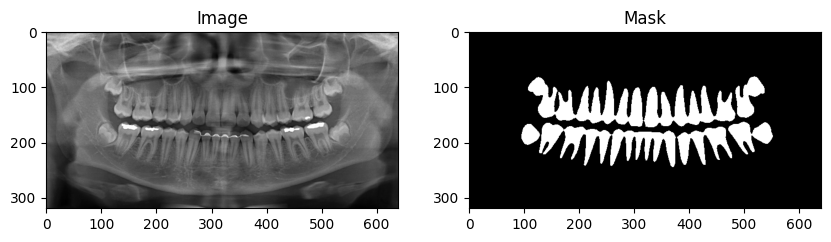

{'img_path': '/content/sts_tooth_data/processed_2d/adult/labeled/images/A_L_622.png', 'mask_path': '/content/sts_tooth_data/processed_2d/adult/labeled/masks/A_L_622.png', 'pair_id': 'a_l_622', 'age_group': 'adult', 'label_status': 'labeled'}
range image : -1.749019742012024 -> 1.6235295534133911
range mask : 0.0 -> 1.0


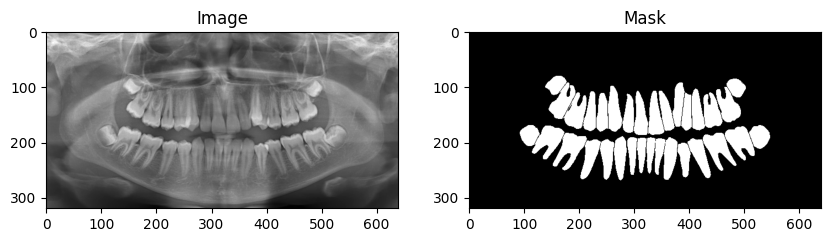

{'img_path': '/content/sts_tooth_data/processed_2d/adult/labeled/images/A_L_797.png', 'mask_path': '/content/sts_tooth_data/processed_2d/adult/labeled/masks/A_L_797.png', 'pair_id': 'a_l_797', 'age_group': 'adult', 'label_status': 'labeled'}
range image : -1.8117648363113403 -> 1.7333334684371948
range mask : 0.0 -> 1.0


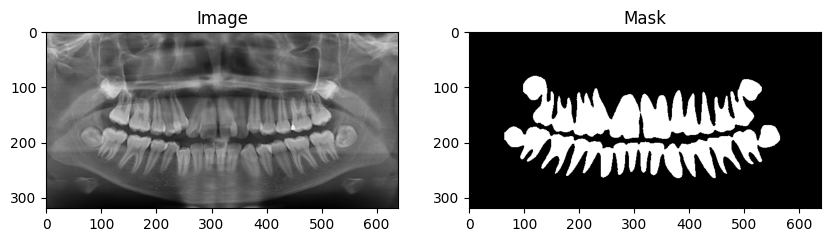

In [29]:
import os
from pathlib import Path
import random

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import matplotlib.pyplot as plt

# --- Re-defining helper functions and Dataset class within this cell ---
# Assuming DATA_ROOT and PROCESSED_2D_DIR are defined in previous cells

# Redefine get_image_path_from_row (from cell Q6Xf1K5x3Aar)
def get_image_path_from_row(row: pd.Series) -> Path:
  rel = Path(row["rel_path"])
  age_group = row["age_group"]
  label_status = row["label_status"]

  # Handle potential "unknown" but in df_pretrain it should be adult/children + labeled/unlabeled
  if age_group not in ("adult", "children"):
      age_group = "unknown"
  if label_status not in ("labeled", "unlabeled"):
      label_status = "unknown"
  img_path = PROCESSED_2D_DIR / age_group / label_status / "images" / rel.name
  return img_path

# Redefine get_mask_path_from_img_path (from cell Q6Xf1K5x3Aar)
def get_mask_path_from_img_path(img_path: Path) -> Path:
  mask_path = img_path.parent.parent / "masks" / img_path.name
  return mask_path

# Redefine load_image_as_array (from cell Q6Xf1K5x3Aar)
def load_image_as_array(path: Path) -> np.ndarray:
    """
    Load a PNG as a grayscale numpy array of shape (H, W), dtype uint8.
    We do NOT normalize or resize here. That will be handled by Albumentations.
    """
    if not path.exists():
        raise FileNotFoundError(f"Image file not found: {path}")
    img = Image.open(path).convert("L")  # "L" = single-channel grayscale
    return np.array(img)

# Corrected load_mask_as_array function
def load_mask_as_array(path: Path) -> np.ndarray:
    """
    Load a PNG mask as a grayscale numpy array of shape (H, W), dtype uint8.
    The mask values should typically be 0 or 255.
    """
    if not path.exists():
        raise FileNotFoundError(f"Mask file not found: {path}")
    mask = Image.open(path).convert("L")  # "L" = single-channel grayscale
    return np.array(mask)

# Modified SupervisedSegmentAnalysis class to handle transform=None gracefully
class SupervisedSegmentAnalysis(Dataset):
    def __init__(
        self,
        df_pretrain: pd.DataFrame,
        transform: Optional[A.Compose], # Allow transform to be None
        num_blocks: int = 8,
        min_block_fraction: float = 0.1,
        max_block_fraction: float = 0.3,
    ):
        self.df = df_pretrain.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]

        img_path = get_image_path_from_row(row)
        img_np = load_image_as_array(img_path)  # (H, W) uint8
        mask_path = get_mask_path_from_img_path(img_path)
        mask_np = load_mask_as_array(mask_path)  # (H, W) uint8 (0 or 255)

        if self.transform is not None:
            # Apply transformations to both image and mask simultaneously
            transformed = self.transform(image=img_np, mask=mask_np)
            img_tensor = transformed["image"]  # (1, H, W), float32, normalized
            mask_tensor = transformed["mask"]  # (H, W) or (1, H, W), float32
        else:
            # No Albumentations transform: manual conversion to tensor
            # Image is scaled to [0,1], mask is converted to float.
            # Note: Normalization (mean/std) is SKIPPED here as per user request for 'no transformation'.
            img_tensor = torch.from_numpy(img_np).float().unsqueeze(0) / 255.0 # Scale to [0,1]
            mask_tensor = torch.from_numpy(mask_np).float().unsqueeze(0) # Keeps mask as [0, 255] initially

        # Ensure mask is binary (0 or 1) and has a channel dimension
        mask_tensor = (mask_tensor > 0.5).float() # Threshold for binary mask
        if mask_tensor.ndim == 2: # Safety check, should already be (1, H, W) from unsqueeze(0)
            mask_tensor = mask_tensor.unsqueeze(0)

        meta = {
            "img_path": str(img_path),
            "mask_path": str(mask_path),
            "pair_id": row["pair_id"],
            "age_group": row["age_group"],
            "label_status": row["label_status"],
        }

        return img_tensor, mask_tensor, meta

# Re-instantiate the dataset with the corrected class definition
dataset = SupervisedSegmentAnalysis(df_pretrain, mim_transform)
print("Dataset created.")
print("number of samples:", len(dataset))
NUM_VIS_SAMPLES = 3

for i in range(NUM_VIS_SAMPLES):
  #print path for both image and mask
  img_tensor, mask_tensor, meta = dataset[i]
  print(meta)
  #convert to numpy for visualization
  img_np = img_tensor.squeeze(0).numpy()
  mask_np = mask_tensor.squeeze(0).numpy()
  print("range image :", float(img_np.min()), "->", float(img_np.max()))
  print("range mask :", float(mask_np.min()), "->", float(mask_np.max()))
  vmin, vmax = img_np.min(), img_np.max()
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(img_np, cmap="gray", vmin=vmin, vmax=vmax)
  axes[0].set_title("Image")
  axes[1].imshow(mask_np, cmap="gray")
  axes[1].set_title("Mask")
  plt.show()

In [26]:
BATCH_SIZE = 4
NUM_WORKERS = 0
train_ds = SupervisedSegmentAnalysis(df_train, transform=mim_transform)
val_ds   = SupervisedSegmentAnalysis(df_val,   transform=None)
test_ds  = SupervisedSegmentAnalysis(df_test,  transform=None)
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
)

print("Dataloaders ready:")
print("  train batches:", len(train_loader))
print("  val batches  :", len(val_loader))
print("  test batches :", len(test_loader))

Dataloaders ready:
  train batches: 158
  val batches  : 34
  test batches : 34


In [18]:
class DoubleConv(nn.Module):
    """(Conv2d -> BN -> ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with MaxPool then DoubleConv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.block(x)


class Up(nn.Module):
    """Upscaling then DoubleConv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1: from previous decoder level
        # x2: from encoder skip connection
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(
            x1,
            [diffX // 2, diffX - diffX // 2,
             diffY // 2, diffY - diffY // 2],
        )

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    """Final 1x1 convolution to produce output channels"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet2D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=32, bilinear=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bilinear = bilinear
        self.base_channels = base_channels

        self.inc = DoubleConv(in_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)
        self.down4 = Down(base_channels * 8, base_channels * 8)

        self.up1 = Up(base_channels * 16, base_channels * 4, bilinear)
        self.up2 = Up(base_channels * 8, base_channels * 2, bilinear)
        self.up3 = Up(base_channels * 4, base_channels, bilinear)
        self.up4 = Up(base_channels * 2, base_channels, bilinear)

        self.outc = OutConv(base_channels, out_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)

        logits = self.outc(x)
        return logits


model = UNet2D(in_channels=1, out_channels=1, base_channels=32, bilinear=True)
model = model.to(device)
print(model)

UNet2D(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (block): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          

In [19]:
bce_loss_fn = nn.BCEWithLogitsLoss()

def dice_loss_from_logits(logits: torch.Tensor, targets: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    Soft Dice loss computed from logits and target masks in {0,1}.
    Args:
        logits:  (B, 1, H, W)
        targets: (B, 1, H, W) in {0,1}
    """
    probs = torch.sigmoid(logits)
    # Flatten per batch
    probs_flat = probs.view(probs.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)

    intersection = (probs_flat * targets_flat).sum(dim=1)
    union = probs_flat.sum(dim=1) + targets_flat.sum(dim=1)

    dice = (2.0 * intersection + eps) / (union + eps)
    return 1.0 - dice.mean()


def combined_segmentation_loss(logits: torch.Tensor, targets: torch.Tensor, lambda_dice: float = 1.0) -> torch.Tensor:
    """
    Combined loss: BCEWithLogits + lambda_dice * DiceLoss
    """
    loss_bce = bce_loss_fn(logits, targets)
    loss_dice = dice_loss_from_logits(logits, targets)
    return loss_bce + lambda_dice * loss_dice


def compute_dice_score(logits: torch.Tensor, targets: torch.Tensor, threshold: float = 0.5, eps: float = 1e-6) -> float:
    """
    Compute foreground Dice coefficient from logits and targets in {0,1}.
    Returns a scalar (mean over batch).
    """
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).float()

    preds_flat = preds.view(preds.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)

    intersection = (preds_flat * targets_flat).sum(dim=1)
    union = preds_flat.sum(dim=1) + targets_flat.sum(dim=1)

    dice = (2.0 * intersection + eps) / (union + eps)
    return dice.mean().item()


def compute_iou_score(logits: torch.Tensor, targets: torch.Tensor, threshold: float = 0.5, eps: float = 1e-6) -> float:
    """
    Compute IoU (Jaccard index) from logits and targets in {0,1}.
    Returns a scalar (mean over batch).
    """
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).float()

    preds_flat = preds.view(preds.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)

    intersection = (preds_flat * targets_flat).sum(dim=1)
    union = preds_flat.sum(dim=1) + targets_flat.sum(dim=1) - intersection

    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

In [20]:
LR = 1e-4
NUM_EPOCHS = 50
PATIENCE = 10  # epochs without val Dice improvement before early stopping

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
print("Optimizer:", optimizer)

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [21]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from pathlib import Path

# Log path：sts_tooth_data/runs/seg_unet
log_dir = DATA_ROOT / "runs" / "seg_unet"
log_dir.mkdir(parents=True, exist_ok=True)

writer = SummaryWriter(log_dir=str(log_dir))
print("TensorBoard log dir:", log_dir)

TensorBoard log dir: /content/sts_tooth_data/runs/seg_unet


In [37]:
from tqdm.auto import tqdm

CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
USE_PRETRAINED = False
best_ckpt_path = CHECKPOINT_DIR / ("unet2d_seg_mim_best.pth" if USE_PRETRAINED else "unet2d_seg_scratch_best.pth")

best_val_dice = 0.0
epochs_without_improvement = 0

global_step = 0

# Removed get_eval_transform() as it's no longer used for val/test datasets.

# Re-initialize the dataset objects for train, validation, and test sets.
# `val_ds` and `test_ds` now receive `transform=None` as per user request.
train_ds = SupervisedSegmentAnalysis(df_train, transform=mim_transform)
val_ds   = SupervisedSegmentAnalysis(df_val,   transform=None)
test_ds  = SupervisedSegmentAnalysis(df_test,  transform=None)
BATCH_SIZE = 16
# Re-initialize the DataLoader objects to use the newly created datasets.
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
)

print("Dataloaders ready after re-initialization:")
print("  train batches:", len(train_loader))
print("  val batches  :", len(val_loader))
print("  test batches :", len(test_loader))


for epoch in range(1, NUM_EPOCHS + 1):
    # -------------------------
    # Training phase
    # -------------------------
    model.train()
    train_loss_sum = 0.0
    train_batches = 0

    # The tqdm progress bar is wrapped in a train_loader layer.
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d} [train]", leave=False)
    for batch in train_pbar:
        imgs, masks, meta = batch
        imgs = imgs.to(device)   # (B, 1, H, W)
        masks = masks.to(device) # (B, 1, H, W)

        optimizer.zero_grad()

        logits = model(imgs)
        loss = combined_segmentation_loss(logits, masks, lambda_dice=0.25)

        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        train_batches += 1
        global_step += 1

        avg_batch_loss = train_loss_sum / train_batches

        # Update the loss displayed on the progress bar.
        train_pbar.set_postfix({"loss": f"{avg_batch_loss:.4f}"})

        # TensorBoard: Records training loss step by step.
        writer.add_scalar("train/loss_step", loss.item(), global_step)

    avg_train_loss = train_loss_sum / max(1, train_batches)
    writer.add_scalar("train/loss_epoch", avg_train_loss, epoch)

    # -------------------------
    # Validation phase
    # -------------------------
    model.eval()
    val_loss_sum = 0.0
    val_batches = 0
    val_dice_sum = 0.0
    val_iou_sum = 0.0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch:02d} [val]", leave=False)
        for batch in val_pbar:
            imgs, masks, meta = batch
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            loss = combined_segmentation_loss(logits, masks, lambda_dice=1.0)

            val_loss_sum += loss.item()
            val_batches += 1

            # metrics
            batch_dice = compute_dice_score(logits, masks)
            batch_iou  = compute_iou_score(logits, masks)

            val_dice_sum += batch_dice
            val_iou_sum  += batch_iou

            avg_val_loss_tmp = val_loss_sum / max(1, val_batches)
            avg_val_dice_tmp = val_dice_sum / max(1, val_batches)

            # The verification progress bar displays the current average value loss / die.
            val_pbar.set_postfix({
                "val_loss": f"{avg_val_loss_tmp:.4f}",
                "val_dice": f"{avg_val_dice_tmp:.4f}",
            })

    avg_val_loss = val_loss_sum / max(1, val_batches)
    avg_val_dice = val_dice_sum / max(1, val_batches)
    avg_val_iou  = val_iou_sum  / max(1, val_batches)

    # TensorBoard: Records validation metrics by epoch.
    writer.add_scalar("val/loss", avg_val_loss, epoch)
    writer.add_scalar("val/dice", avg_val_dice, epoch)
    writer.add_scalar("val/iou",  avg_val_iou,  epoch)
    writer.flush()

    print(
        f"Epoch [{epoch:02d}/{NUM_EPOCHS}] "
        f"- Train loss: {avg_train_loss:.4f} "
        f"- Val loss: {avg_val_loss:.4f} "
        f"- Val Dice: {avg_val_dice:.4f} "
        f"- Val IoU: {avg_val_iou:.4f}"
    )

    # -------------------------
    # Check for improvement (by val Dice)
    # -------------------------
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_ckpt_path)
        print(f"  -> New best val Dice: {best_val_dice:.4f}. Saved checkpoint to {best_ckpt_path}")
    else:
        epochs_without_improvement += 1
        print(f"  -> No improvement in Dice for {epochs_without_improvement} epoch(s).")

    # Early stopping
    if epochs_without_improvement >= PATIENCE:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

writer.close()

Dataloaders ready after re-initialization:
  train batches: 40
  val batches  : 9
  test batches : 9


Epoch 01 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 01 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [01/50] - Train loss: 0.1184 - Val loss: 1.3477 - Val Dice: 0.2608 - Val IoU: 0.1664
  -> New best val Dice: 0.2608. Saved checkpoint to /content/sts_tooth_data/checkpoints/unet2d_seg_scratch_best.pth


Epoch 02 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 02 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [02/50] - Train loss: 0.1135 - Val loss: 1.0167 - Val Dice: 0.4636 - Val IoU: 0.3249
  -> New best val Dice: 0.4636. Saved checkpoint to /content/sts_tooth_data/checkpoints/unet2d_seg_scratch_best.pth


Epoch 03 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 03 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [03/50] - Train loss: 0.1108 - Val loss: 1.0504 - Val Dice: 0.4260 - Val IoU: 0.2986
  -> No improvement in Dice for 1 epoch(s).


Epoch 04 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 04 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [04/50] - Train loss: 0.1091 - Val loss: 1.1735 - Val Dice: 0.3618 - Val IoU: 0.2428
  -> No improvement in Dice for 2 epoch(s).


Epoch 05 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 05 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [05/50] - Train loss: 0.1094 - Val loss: 1.3111 - Val Dice: 0.2762 - Val IoU: 0.1807
  -> No improvement in Dice for 3 epoch(s).


Epoch 06 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 06 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [06/50] - Train loss: 0.1087 - Val loss: 1.0732 - Val Dice: 0.4191 - Val IoU: 0.2907
  -> No improvement in Dice for 4 epoch(s).


Epoch 07 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 07 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [07/50] - Train loss: 0.1071 - Val loss: 1.0632 - Val Dice: 0.4450 - Val IoU: 0.3101
  -> No improvement in Dice for 5 epoch(s).


Epoch 08 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 08 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [08/50] - Train loss: 0.1081 - Val loss: 1.0766 - Val Dice: 0.4280 - Val IoU: 0.2949
  -> No improvement in Dice for 6 epoch(s).


Epoch 09 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 09 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [09/50] - Train loss: 0.1059 - Val loss: 0.9704 - Val Dice: 0.4905 - Val IoU: 0.3522
  -> New best val Dice: 0.4905. Saved checkpoint to /content/sts_tooth_data/checkpoints/unet2d_seg_scratch_best.pth


Epoch 10 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [10/50] - Train loss: 0.1035 - Val loss: 0.9802 - Val Dice: 0.4836 - Val IoU: 0.3450
  -> No improvement in Dice for 1 epoch(s).


Epoch 11 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [11/50] - Train loss: 0.1060 - Val loss: 1.1541 - Val Dice: 0.3885 - Val IoU: 0.2647
  -> No improvement in Dice for 2 epoch(s).


Epoch 12 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [12/50] - Train loss: 0.1030 - Val loss: 1.1770 - Val Dice: 0.3899 - Val IoU: 0.2638
  -> No improvement in Dice for 3 epoch(s).


Epoch 13 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [13/50] - Train loss: 0.1008 - Val loss: 0.8355 - Val Dice: 0.5763 - Val IoU: 0.4295
  -> New best val Dice: 0.5763. Saved checkpoint to /content/sts_tooth_data/checkpoints/unet2d_seg_scratch_best.pth


Epoch 14 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [14/50] - Train loss: 0.1000 - Val loss: 1.1634 - Val Dice: 0.3848 - Val IoU: 0.2613
  -> No improvement in Dice for 1 epoch(s).


Epoch 15 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [15/50] - Train loss: 0.0998 - Val loss: 0.9566 - Val Dice: 0.4991 - Val IoU: 0.3585
  -> No improvement in Dice for 2 epoch(s).


Epoch 16 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [16/50] - Train loss: 0.0987 - Val loss: 0.9400 - Val Dice: 0.5086 - Val IoU: 0.3654
  -> No improvement in Dice for 3 epoch(s).


Epoch 17 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [17/50] - Train loss: 0.0985 - Val loss: 0.9134 - Val Dice: 0.5343 - Val IoU: 0.3925
  -> No improvement in Dice for 4 epoch(s).


Epoch 18 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [18/50] - Train loss: 0.0984 - Val loss: 1.2707 - Val Dice: 0.3127 - Val IoU: 0.2057
  -> No improvement in Dice for 5 epoch(s).


Epoch 19 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [19/50] - Train loss: 0.0984 - Val loss: 0.9860 - Val Dice: 0.4838 - Val IoU: 0.3446
  -> No improvement in Dice for 6 epoch(s).


Epoch 20 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [20/50] - Train loss: 0.0959 - Val loss: 1.3461 - Val Dice: 0.2983 - Val IoU: 0.1945
  -> No improvement in Dice for 7 epoch(s).


Epoch 21 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [21/50] - Train loss: 0.0977 - Val loss: 1.1324 - Val Dice: 0.4112 - Val IoU: 0.2826
  -> No improvement in Dice for 8 epoch(s).


Epoch 22 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [22/50] - Train loss: 0.0954 - Val loss: 1.0090 - Val Dice: 0.4926 - Val IoU: 0.3483
  -> No improvement in Dice for 9 epoch(s).


Epoch 23 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [23/50] - Train loss: 0.0946 - Val loss: 0.8286 - Val Dice: 0.5965 - Val IoU: 0.4446
  -> New best val Dice: 0.5965. Saved checkpoint to /content/sts_tooth_data/checkpoints/unet2d_seg_scratch_best.pth


Epoch 24 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [24/50] - Train loss: 0.0939 - Val loss: 1.0885 - Val Dice: 0.4539 - Val IoU: 0.3163
  -> No improvement in Dice for 1 epoch(s).


Epoch 25 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [25/50] - Train loss: 0.0941 - Val loss: 1.1019 - Val Dice: 0.4485 - Val IoU: 0.3125
  -> No improvement in Dice for 2 epoch(s).


Epoch 26 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [26/50] - Train loss: 0.0916 - Val loss: 0.8992 - Val Dice: 0.5461 - Val IoU: 0.3980
  -> No improvement in Dice for 3 epoch(s).


Epoch 27 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [27/50] - Train loss: 0.0924 - Val loss: 0.8362 - Val Dice: 0.5905 - Val IoU: 0.4365
  -> No improvement in Dice for 4 epoch(s).


Epoch 28 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [28/50] - Train loss: 0.0929 - Val loss: 0.9416 - Val Dice: 0.5422 - Val IoU: 0.3904
  -> No improvement in Dice for 5 epoch(s).


Epoch 29 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [29/50] - Train loss: 0.0925 - Val loss: 1.5587 - Val Dice: 0.2251 - Val IoU: 0.1396
  -> No improvement in Dice for 6 epoch(s).


Epoch 30 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [30/50] - Train loss: 0.0917 - Val loss: 1.0600 - Val Dice: 0.4719 - Val IoU: 0.3300
  -> No improvement in Dice for 7 epoch(s).


Epoch 31 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [31/50] - Train loss: 0.0917 - Val loss: 1.1920 - Val Dice: 0.4026 - Val IoU: 0.2716
  -> No improvement in Dice for 8 epoch(s).


Epoch 32 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [32/50] - Train loss: 0.0892 - Val loss: 0.8474 - Val Dice: 0.5897 - Val IoU: 0.4397
  -> No improvement in Dice for 9 epoch(s).


Epoch 33 [train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33 [val]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [33/50] - Train loss: 0.0883 - Val loss: 0.8644 - Val Dice: 0.5793 - Val IoU: 0.4292
  -> No improvement in Dice for 10 epoch(s).
Early stopping triggered at epoch 33.


In [38]:
if best_ckpt_path.exists():
    state_dict = torch.load(best_ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    print("Loaded best segmentation checkpoint from:", best_ckpt_path)
else:
    print("WARNING: Best checkpoint not found, using current model weights.")

model.eval()

test_loss_sum = 0.0
test_batches = 0
test_dice_sum = 0.0
test_iou_sum = 0.0

with torch.no_grad():
    for batch in test_loader:
        imgs, masks, meta = batch
        imgs = imgs.to(device)
        masks = masks.to(device)

        logits = model(imgs)
        loss = combined_segmentation_loss(logits, masks, lambda_dice=1.0)
        test_loss_sum += loss.item()
        test_batches += 1

        batch_dice = compute_dice_score(logits, masks)
        batch_iou  = compute_iou_score(logits, masks)

        test_dice_sum += batch_dice
        test_iou_sum  += batch_iou

avg_test_loss = test_loss_sum / max(1, test_batches)
avg_test_dice = test_dice_sum / max(1, test_batches)
avg_test_iou  = test_iou_sum  / max(1, test_batches)

print("\n=== Test set evaluation ===")
print(f"Test loss: {avg_test_loss:.4f}")
print(f"Test Dice: {avg_test_dice:.4f}")
print(f"Test IoU : {avg_test_iou:.4f}")

Loaded best segmentation checkpoint from: /content/sts_tooth_data/checkpoints/unet2d_seg_scratch_best.pth

=== Test set evaluation ===
Test loss: 0.8273
Test Dice: 0.6012
Test IoU : 0.4506


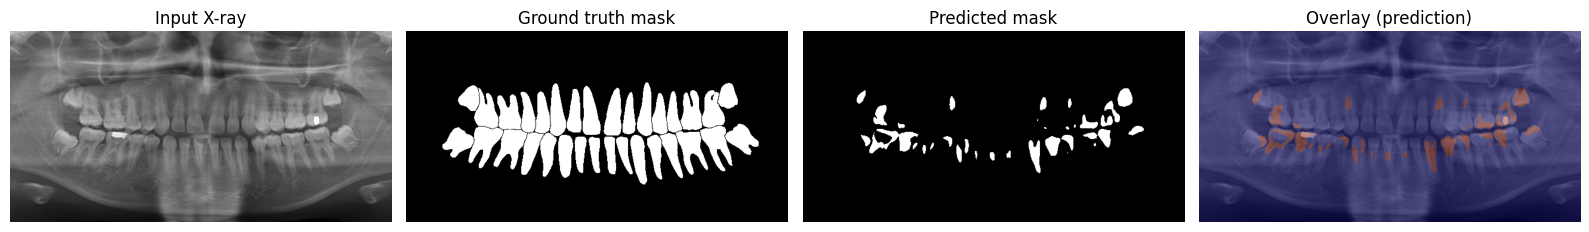

Image path: /content/sts_tooth_data/processed_2d/adult/labeled/images/A_L_252.png


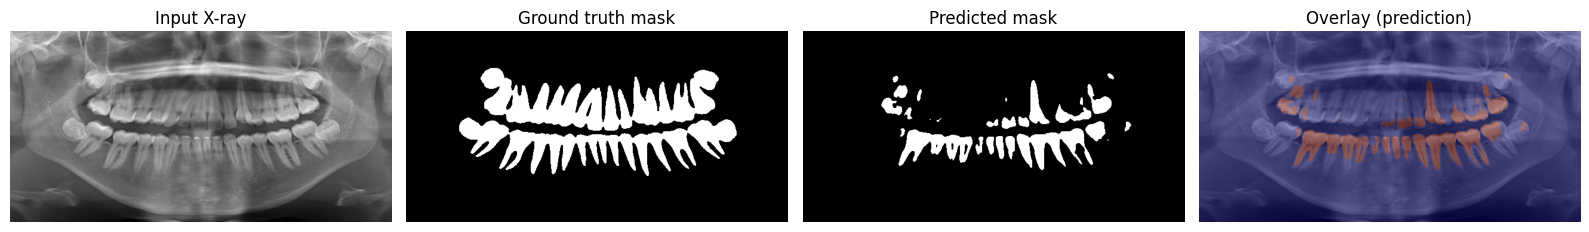

Image path: /content/sts_tooth_data/processed_2d/adult/labeled/images/A_L_159.png


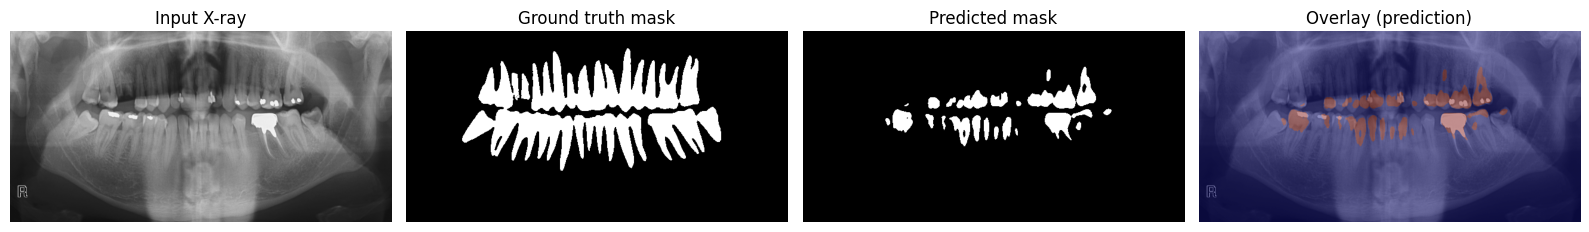

Image path: /content/sts_tooth_data/processed_2d/adult/labeled/images/A_L_585.png


In [39]:
# ## 13. Qualitative visualization (optional)
#
# We visualize a few samples from the test set:
# - Input X-ray
# - Ground truth mask
# - Predicted mask (thresholded at 0.5)
# - Overlay
# %%
NUM_VIS_SAMPLES = 3

model.eval()
with torch.no_grad():
    count = 0
    for imgs, masks, meta in test_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        logits = model(imgs)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()

        for b in range(imgs.size(0)):
            if count >= NUM_VIS_SAMPLES:
                break

            img_np   = imgs[b].cpu().squeeze(0).numpy()
            gt_np    = masks[b].cpu().squeeze(0).numpy()
            pred_np  = preds[b].cpu().squeeze(0).numpy()

            fig, axes = plt.subplots(1, 4, figsize=(16, 4))

            axes[0].imshow(img_np, cmap="gray")
            axes[0].set_title("Input X-ray")
            axes[0].axis("off")

            axes[1].imshow(gt_np, cmap="gray")
            axes[1].set_title("Ground truth mask")
            axes[1].axis("off")

            axes[2].imshow(pred_np, cmap="gray")
            axes[2].set_title("Predicted mask")
            axes[2].axis("off")

            # Overlay prediction on input
            axes[3].imshow(img_np, cmap="gray")
            axes[3].imshow(pred_np, alpha=0.4, cmap="jet")
            axes[3].set_title("Overlay (prediction)")
            axes[3].axis("off")

            plt.tight_layout()
            plt.show()

            print("Image path:", meta["img_path"][b])
            count += 1

        if count >= NUM_VIS_SAMPLES:
            break